In [270]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import astropy.units as u
import starry

starry.config.lazy = False
starry.config.quiet = True

In [271]:
map = starry.Map(ydeg=15, reflected=True)
#map.show()

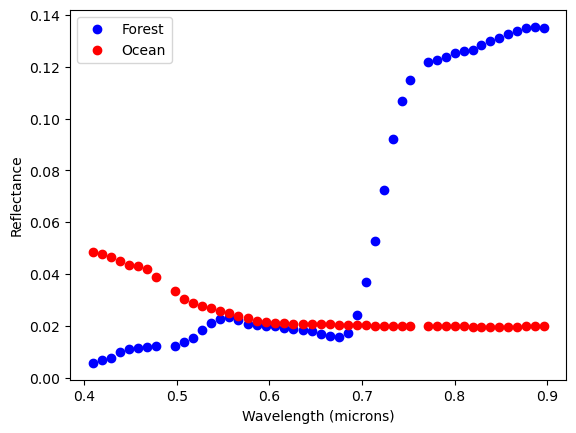

In [272]:
#Write txt file data into a numpy array, ignoring the first row
ocean_wav = np.loadtxt('/Users/andrew/Desktop/QMUL/PhD/photosynth/spectra/splib07a_Seawater_Open_Ocean_SW2_lwch_BECKa_AREF/splib07a_Wavelengths_BECK_Beckman_0.2-3.0_microns.txt', skiprows=1)
ocean_refl = np.loadtxt('/Users/andrew/Desktop/QMUL/PhD/photosynth/spectra/splib07a_Seawater_Open_Ocean_SW2_lwch_BECKa_AREF/splib07a_Seawater_Open_Ocean_SW2_lwch_BECKa_AREF.txt', skiprows=1)

forest_wav = np.loadtxt('/Users/andrew/Desktop/QMUL/PhD/photosynth/spectra/splib07a_Douglas-Fir_YNP-DF-1_forest_AVIRISb_RTGC/splib07a_Wavelengths_AVIRIS_1996_0.37-2.5_microns.txt', skiprows=1)
forest_refl = np.loadtxt('/Users/andrew/Desktop/QMUL/PhD/photosynth/spectra/splib07a_Douglas-Fir_YNP-DF-1_forest_AVIRISb_RTGC/splib07a_Douglas-Fir_YNP-DF-1_forest_AVIRISb_RTGC.txt', skiprows=1)

forest_wav = np.delete(forest_wav, np.where(forest_refl < 0))
forest_refl = np.delete(forest_refl, np.where(forest_refl < 0))
forest_refl = np.delete(forest_refl, np.where(forest_wav > 1))
forest_wav = np.delete(forest_wav, np.where(forest_wav > 1))
ocean_refl = np.delete(ocean_refl, np.where(ocean_wav > 1))
ocean_wav = np.delete(ocean_wav, np.where(ocean_wav > 1))  


forest_wav = forest_wav[:49]
forest_refl = forest_refl[:49]

i = np.where((ocean_wav < forest_wav[0]))

ocean_wav = np.delete(ocean_wav, i)
ocean_refl = np.delete(ocean_refl, i)

sum = 0
i = 0
num = 0
j = 0

while i < len(ocean_wav) and j < (len(forest_wav)-1):
    if ocean_wav[i] < forest_wav[j+1]:
        sum = sum + ocean_refl[i]
        i = i + 1
        num = num + 1
    else:
        ocean_refl[j] = sum / num
        ocean_wav[j] = forest_wav[j]
        j = j + 1
        sum = num = 0

ocean_wav = ocean_wav[:49]
ocean_refl = ocean_refl[:49]
ocean_wav[48] = forest_wav[48]
ocean_refl[48] = ocean_refl[47]

plt.plot(forest_wav, forest_refl, 'ob', label='Forest')
plt.plot(ocean_wav, ocean_refl, 'or', label='Ocean')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

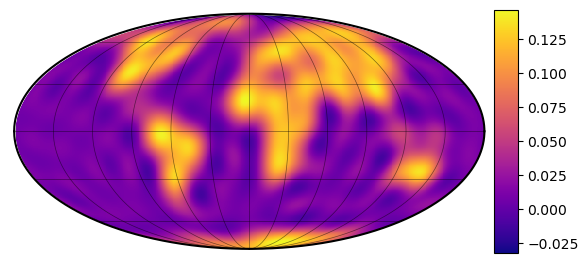

In [273]:
map.load("earth", smoothing = 0.)
map.amp *= 0.4
map.show(projection="moll", illuminate=False, res=500, colorbar=True)

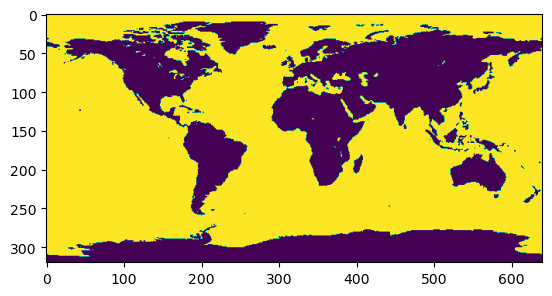

In [274]:
earth_refl_spec = np.ones((49, 320, 640))

for wl in range(49):
    image = plt.imread('/Users/andrew/Documents/starry/starry/img/earth.png')
    image[image < 0.5] = ocean_refl[wl]
    image[image >= 0.5] = forest_refl[wl]
    earth_refl_spec[wl] = image
    
plt.imshow(earth_refl_spec[0])



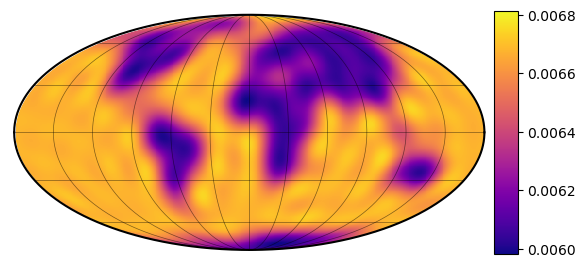

In [292]:
map.load(np.flipud(earth_refl_spec[20]))
map.show(projection="moll", illuminate=False, res=500, colorbar=True)

In [276]:
ydeg = 15
specmap_y = np.zeros((49, (ydeg+1)**2))

for wl in range(49):
    map = starry.Map(ydeg=ydeg, reflected=True)
    map.load(np.flipud(earth_refl_spec[wl]))
    specmap_y[wl] = map.y


In [277]:
print(specmap_y.shape)

(49, 256)


In [278]:
specmap = starry.Map(ydeg=ydeg, reflected=True, nw = 49)

for wl in range(49):
    c = 0
    l = 1
    while l <= ydeg:
        m = -l
        while m <= l:
            specmap[l,m,wl] = specmap_y[wl][c]
            m += 1
            c += 1
        l += 1

In [279]:
print(specmap.y.shape)

(256, 49)


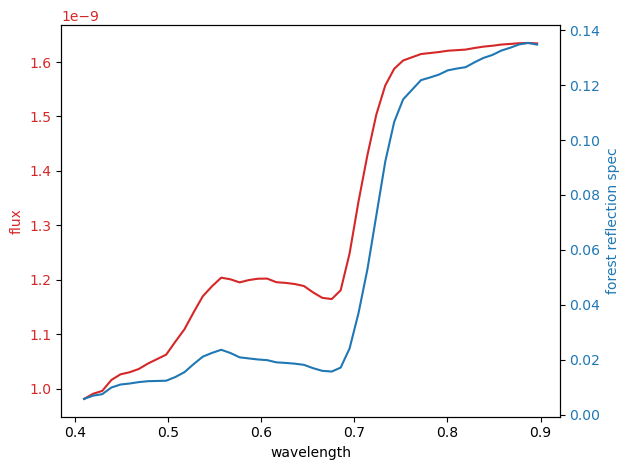

In [280]:
r = 150E6/6400. # Earth - Sun distance in units of Earth radii

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('wavelength')
ax1.set_ylabel('flux', color=color)
ax1.plot(forest_wav, specmap.flux(theta = 20, zs = r).reshape(-1), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('forest reflection spec', color=color)  # we already handled the x-label with ax1
ax2.plot(forest_wav, forest_refl, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [281]:
theta = np.linspace(0, 360, 1000)
flux_full = specmap.flux(theta = theta, xs = 0, ys = 0, zs = r, normalize = False)
print(flux_full.shape)

(1000, 49)


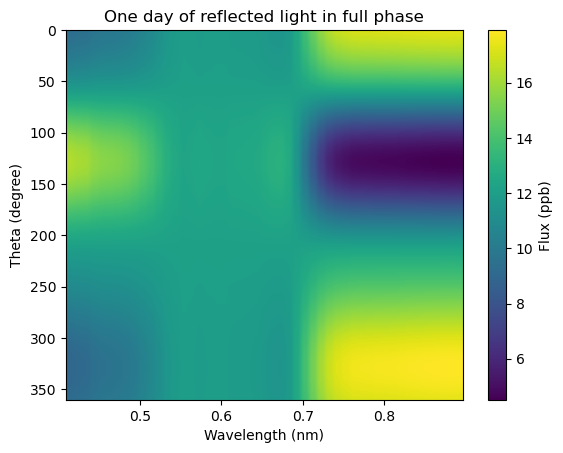

In [282]:
#make a color map plot with forest.wav on the x axis and theta on the y axis, with flux as the color

# Create a figure and axes
fig, ax = plt.subplots()

# Use the "viridis" colormap for flux
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=np.min(flux_full*10E9), vmax=np.max(flux_full*10E9))

# Plot the flux as an image with color mapping
im = ax.imshow(flux_full*10E9, cmap=cmap, norm=norm, aspect='auto',
               extent=(forest_wav[0], forest_wav[-1], theta[-1], theta[0]))

# Add a color bar to show the mapping
cbar = ax.figure.colorbar(im, ax=ax)

# Add labels and titles
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Theta (degree)')
cbar.ax.set_ylabel('Flux (ppb)')
ax.set_title('One day of reflected light in full phase')

# Show the plot
plt.show()

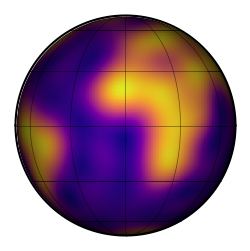

In [291]:
map.show(theta=360, xs=0, ys=0, zs=r)

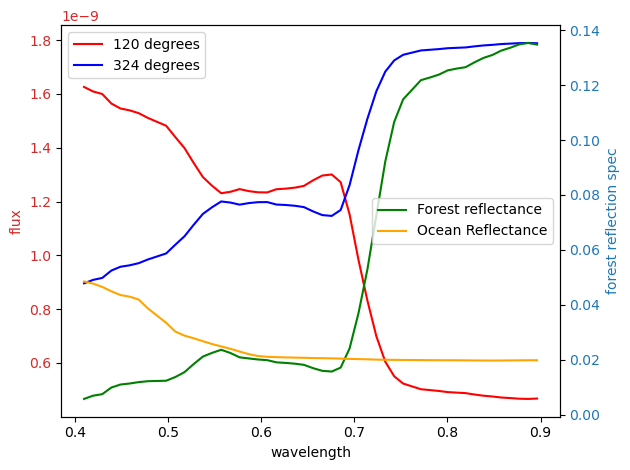

In [297]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('wavelength')
ax1.set_ylabel('flux', color=color)
ax1.plot(forest_wav, flux_full[333], label='120 degrees', color= 'red')
ax1.plot(forest_wav, flux_full[900], label='324 degrees', color= 'blue')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc = 'upper left')
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('forest reflection spec', color=color)  # we already handled the x-label with ax1
ax2.plot(forest_wav, forest_refl, label='Forest reflectance', color='green')
ax2.plot(forest_wav, ocean_refl, label='Ocean Reflectance', color='orange')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc = 'right')
fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

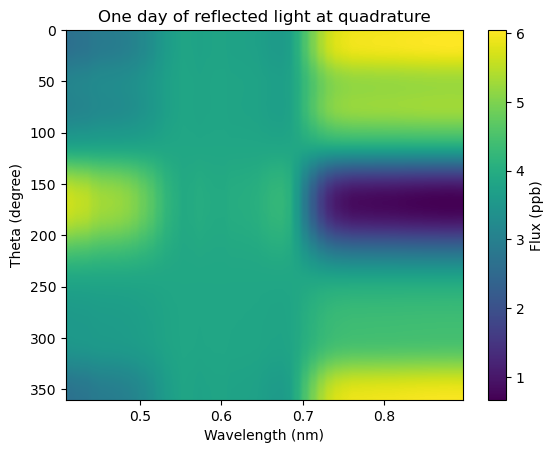

In [283]:
theta = np.linspace(0, 360, 1000)
flux_quad = specmap.flux(theta = theta, xs=r, ys = 0, zs=0, normalize = False)

# Create a figure and axes
fig, ax = plt.subplots()

# Use the "viridis" colormap for flux
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=np.min(flux_quad*10E9), vmax=np.max(flux_quad*10E9))

# Plot the flux as an image with color mapping
im = ax.imshow(flux_quad*10E9, cmap=cmap, norm=norm, aspect='auto',
               extent=(forest_wav[0], forest_wav[-1], theta[-1], theta[0]))

# Add a color bar to show the mapping
cbar = ax.figure.colorbar(im, ax=ax)

# Add labels and titles
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Theta (degree)')
cbar.ax.set_ylabel('Flux (ppb)')
ax.set_title('One day of reflected light at quadrature')

# Show the plot
plt.show()

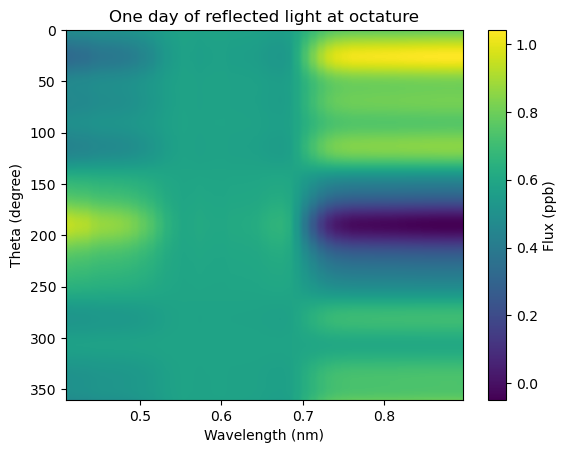

In [284]:
theta = np.linspace(0, 360, 1000)
flux_cres = specmap.flux(theta = theta, xs= r * np.sqrt(2.)/2., ys = 0, zs= -r * np.sqrt(2.)/2.)

# Create a figure and axes
fig, ax = plt.subplots()

# Use the "viridis" colormap for flux
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=np.min(flux_cres*10E9), vmax=np.max(flux_cres*10E9))

# Plot the flux as an image with color mapping
im = ax.imshow(flux_cres*10E9, cmap=cmap, norm=norm, aspect='auto',
               extent=(forest_wav[0], forest_wav[-1], theta[-1], theta[0]))

# Add a color bar to show the mapping
cbar = ax.figure.colorbar(im, ax=ax)

# Add labels and titles
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Theta (degree)')
cbar.ax.set_ylabel('Flux (ppb)')
ax.set_title('One day of reflected light at octature')

# Show the plot
plt.show()

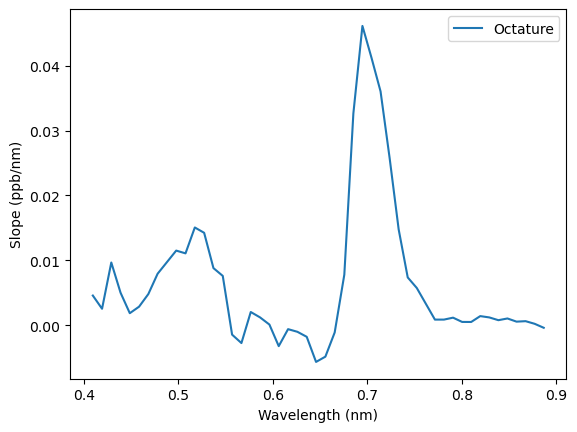

In [299]:
slope_full = np.diff(flux_full*10E9, axis = 1)
slope_quad = np.diff(flux_quad*10E9, axis = 1)
slope_cres = np.diff(flux_cres*10E9, axis = 1)

plt.plot(forest_wav[:-1], slope_full[0], label = 'Full')
plt.plot(forest_wav[:-1], slope_quad[0], label = 'Quadrature')
plt.plot(forest_wav[:-1], slope_cres[0], label = 'Octature')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Slope (ppb/nm)')
plt.legend()


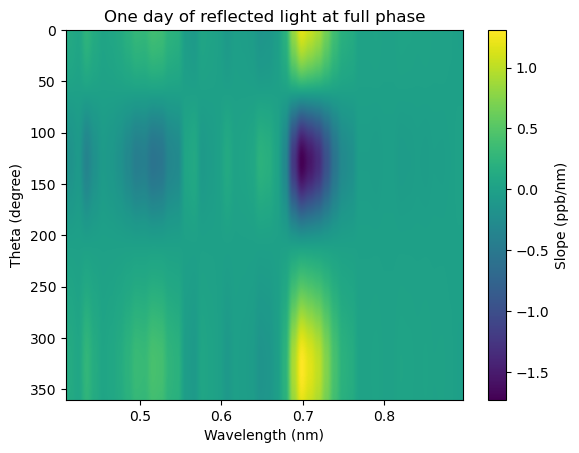

In [288]:
# Create a figure and axes
fig, ax = plt.subplots()

# Use the "viridis" colormap for flux
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=np.min(slope_full), vmax=np.max(slope_full))

# Plot the flux as an image with color mapping
im = ax.imshow(slope_full, cmap=cmap, norm=norm, aspect='auto',
               extent=(forest_wav[0], forest_wav[-1], theta[-1], theta[0]))

# Add a color bar to show the mapping
cbar = ax.figure.colorbar(im, ax=ax)

# Add labels and titles
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Theta (degree)')
cbar.ax.set_ylabel('Slope (ppb/nm)')
ax.set_title('One day of reflected light at full phase')

# Show the plot
plt.show()